##### 一、环境配置

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# 修改imputer为SimpleImputer
# from sklearn.preprocessi|ng import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
from sklearn import metrics

import seaborn as sns
# from sklearn.metrics import roc_curve, auc, roc_auc_score

##### 二、数据读取和预处理

In [2]:
# 定义服务器根路径
# root =  '/root/cai/Baseline_FM/HumanActivityRecognize-master/HumanActivityRecognize-master/Data/UCI_HAR_Dataset/'
# 定义本机根路径
# root =  '/Users/authorcai/Documents/Authorcai/CSH/HumanActivityRecognize-master/Data/UCI_HAR_Dataset/'
# 定义win10下根本目录
root = 'C:/Users/Authorcai/CSH/HumanActivityRecognization/UCI_HAR_Dataset/UCI_HAR_Dataset/'
# 读取数据
features = pd.read_csv(root + 'features.txt', sep='\s+', index_col=0, header=None)
train_data = pd.read_csv(root + 'train/X_train.txt', sep='\s+')
test_data = pd.read_csv(root + 'test/X_test.txt', sep='\s+')

train_data.columns = list(features.values.ravel())
test_data.columns = list(features.values.ravel())

train_label = pd.read_csv(root + 'train/y_train.txt', sep='\s+', header=None)
test_label = pd.read_csv(root + 'test/y_test.txt', sep='\s+', header=None)
label_name = pd.read_csv(root + 'activity_labels.txt', sep='\s+', header=None)

# drop掉label_name自带的索引列
label_name = label_name.drop(columns=0,axis=1)

In [3]:
# 处理label数据
def get_label_name(num):
    return label_name.iloc[num-1,0]#在原来的标签号基础上减一
train_data['label']=train_label
test_data['label']=test_label
# 匹配索引号和对应姿势名称
train_data['label_name']=train_data['label'].map(get_label_name)
test_data['label_name']=test_data['label'].map(get_label_name)

In [4]:
# 将初始数据的空值用NaN替代
train_data.replace("?",np.NaN).head()
test_data.replace("?",np.NaN).head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",label,label_name
0,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,5,STANDING
1,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,5,STANDING
2,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,5,STANDING
3,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,5,STANDING
4,0.279220,-0.018620,-0.113902,-0.994455,-0.970417,-0.965316,-0.994585,-0.969481,-0.965897,-0.937856,...,-0.857565,-0.095681,0.048849,0.760684,-0.072216,-0.689816,0.294896,-0.068471,5,STANDING


In [5]:
#制作训练集和测试集，使格式符合sklean算法要求
x_train=train_data.iloc[:,:-2].values # 训练集X特征数据
x_test=train_data.iloc[:,-2].values # 训练集X标签数据
y_train=test_data.iloc[:,:-2].values # 测试集Y合特征数据
y_test=test_data.iloc[:,-2].values # 测试集Y标签数据


##### 三、对比实验

In [6]:
names = {
    1:'WALKING',
    2:'WALKING_UPSTAIRS',
    3:'WALKING_DOWNSTAIRS',
    4:'SITTING',
    5:'STANDING',
    6:'LAYING'
}

In [12]:
# 定义函数用于生成混淆矩阵
def CreateCM(prediction,y_true,name):
    # 查看结果
    prediction_new = pd.DataFrame(prediction)
    prediction_new.columns=['activity']
    # 对预测结果数量进行统计
    # prediction_new['activity'].value_counts()
    # 对预测结果标签进行数字替换，按names进行替换
    prediction_new['activity']= prediction_new['activity'].map(names)
    # 查看预测结果信息
    # prediction_new['activity'].describe()
    # prediction_new['activity'].value_counts()
    
#     # 对prediciton 作-1处理
#     i = 0
#     for value in prediction:
#         prediction[i]=value-1
#         i = i+1
#     # 对y_test 作-1处理
#     i = 0
#     for value in y_test:
#         y_true[i]=value-1
#         i = i+1
    # 混淆矩阵可视化
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import plot_confusion_matrix
    # 生成获取混淆矩阵
    cm = confusion_matrix(y_true=y_true,y_pred=prediction)   
    
    # 混淆矩阵信息添加
    columns = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    cm_df = pd.DataFrame(cm)
    cm_df.columns = columns
    cm_df.index = columns

    #转换成dataframe，转不转一样
    #fmt参数不使用科学计数法进行显示
#     plt.xticks(fontsize=8) 
#     plt.yticks(fontsize=8)
    ax = sns.heatmap(cm_df,annot=True,fmt='.20g',center=120,vmin=0,vmax=600)
    ax.set_title('confusion matrix') #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    
    # 存储图片
    # plt.savefig('论文图表资料/其他对比算法的预测结果（混淆矩阵展示）/'+name+'.tif',format='tif',bbox_inches='tight')
    # 设置xy轴刻度文字大小 
    return cm

In [13]:
#test
a = np.array([
    [1,2,3],
    [1,2,3],
    [1,2,3]
])


In [14]:
# 定义函数用于输出精确率和召回率
def process(cm):
    x = [0,0,0,0,0,0]
    y = [0,0,0,0,0,0]
    for i in range(0,6):
        sumrow_i = sum(cm[i])
        sumcol_i = sum(cm.T[i])

        x[i] = cm[i][i]/sumrow_i
        y[i] = cm[i][i]/sumcol_i
    print("精确率：",np.sum(x)/6*100,'%' )
    print("召回率：",np.sum(y)/6*100,'%' )

###### （一）KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
 
clf = KNeighborsClassifier()
clf.fit(x_train, x_test)
prediction = clf.predict(y_train)

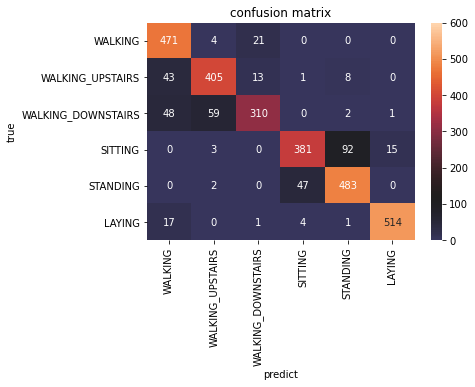

In [16]:
# 计算混淆矩阵
c = CreateCM(prediction,y_test,'KNN')

In [17]:
# 输出精确率和召回率
process(c)

精确率： 86.50709583658629 %
召回率： 87.3701672935132 %


###### （二）SVM

In [18]:
### SVM Classifier    
from sklearn.svm import SVC
 
clf = SVC(kernel='rbf', probability=True)
clf.fit(x_train, x_test)
prediction = clf.predict(y_train)

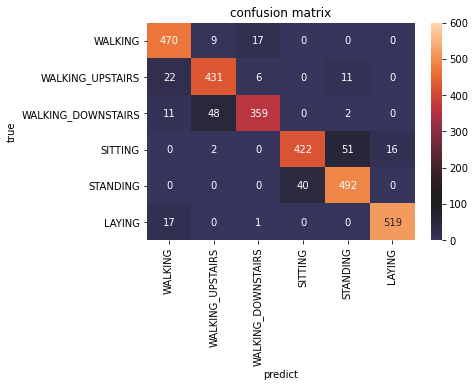

In [19]:
c = CreateCM(prediction,y_test,'SVM')

In [20]:
# 输出精确率和召回率
process(c)

精确率： 91.16877953255457 %
召回率： 91.48633771495052 %


###### （三）QDA

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
 
clf = QuadraticDiscriminantAnalysis()
clf.fit(x_train, x_test)
prediction = clf.predict(y_train)

C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


array([[329, 102,  65,   0,   0,   0],
       [ 39, 355,  72,   0,   4,   0],
       [104,  93, 222,   0,   1,   0],
       [  0,  16,   2, 298, 155,  20],
       [  0,  59,   3,  33, 436,   1],
       [  7,   6,   5,   4,   0, 515]], dtype=int64)

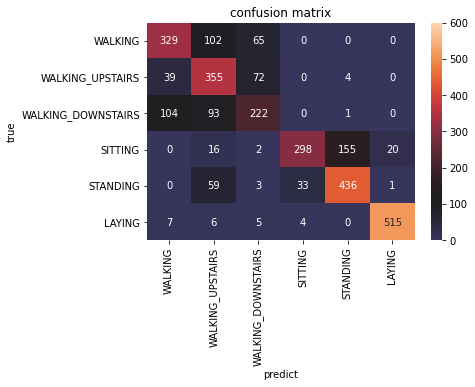

In [22]:
c = CreateCM(prediction,y_test,'QDA')
c

In [23]:
# 输出精确率和召回率
process(c)

精确率： 72.21170337068591 %
召回率： 73.88315705071481 %


###### （四）GaussianNB

In [24]:
# GaussianNB
from sklearn.naive_bayes import GaussianNB
 
clf = GaussianNB()
clf.fit(x_train, x_test)
prediction = clf.predict(y_train)

In [25]:
prediction.shape

(2946,)

array([[380,  69,  47,   0,   0,   0],
       [ 14, 431,  12,   0,   6,   7],
       [ 88,  91, 239,   0,   1,   1],
       [  0,   2,   0,  78, 392,  19],
       [  0,   0,   0,  10, 480,  42],
       [ 10,   7,   1, 500,   0,  19]], dtype=int64)

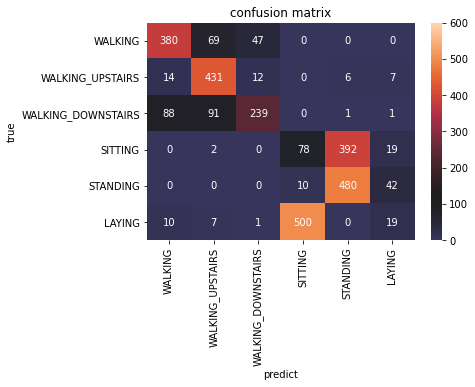

In [26]:
c = CreateCM(prediction,y_test,'GaussianNB')
c

In [27]:
# 输出精确率和召回率
process(c)

精确率： 55.8115797988859 %
召回率： 53.07765663412186 %


###### (五)MLP

array([[476,   8,   6,   0,   0,   6],
       [ 28, 419,  14,   0,   8,   1],
       [ 51,  46, 321,   0,   1,   1],
       [  0,   3,   0, 410,  68,  10],
       [  1,   8,   1,  16, 506,   0],
       [ 16,   0,   0,   0,  11, 510]], dtype=int64)

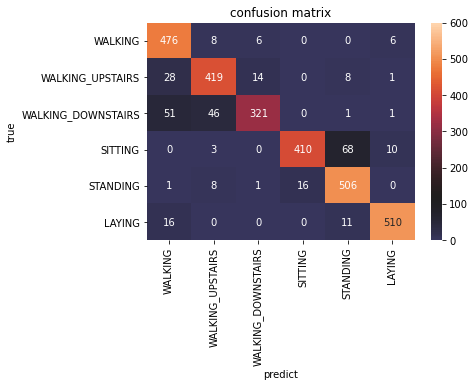

In [28]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,x_test)
prediction = mlp.predict(y_train)
c = CreateCM(prediction,y_test,'MLP')
c

In [29]:
# 输出精确率和召回率
process(c)

精确率： 89.18885891967969 %
召回率： 90.27781766749465 %


###### (六)LR

C:\Users\Authorcai\.conda\envs\Cloth\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


精确率： 90.66090206195686 %
召回率： 91.04262898289876 %


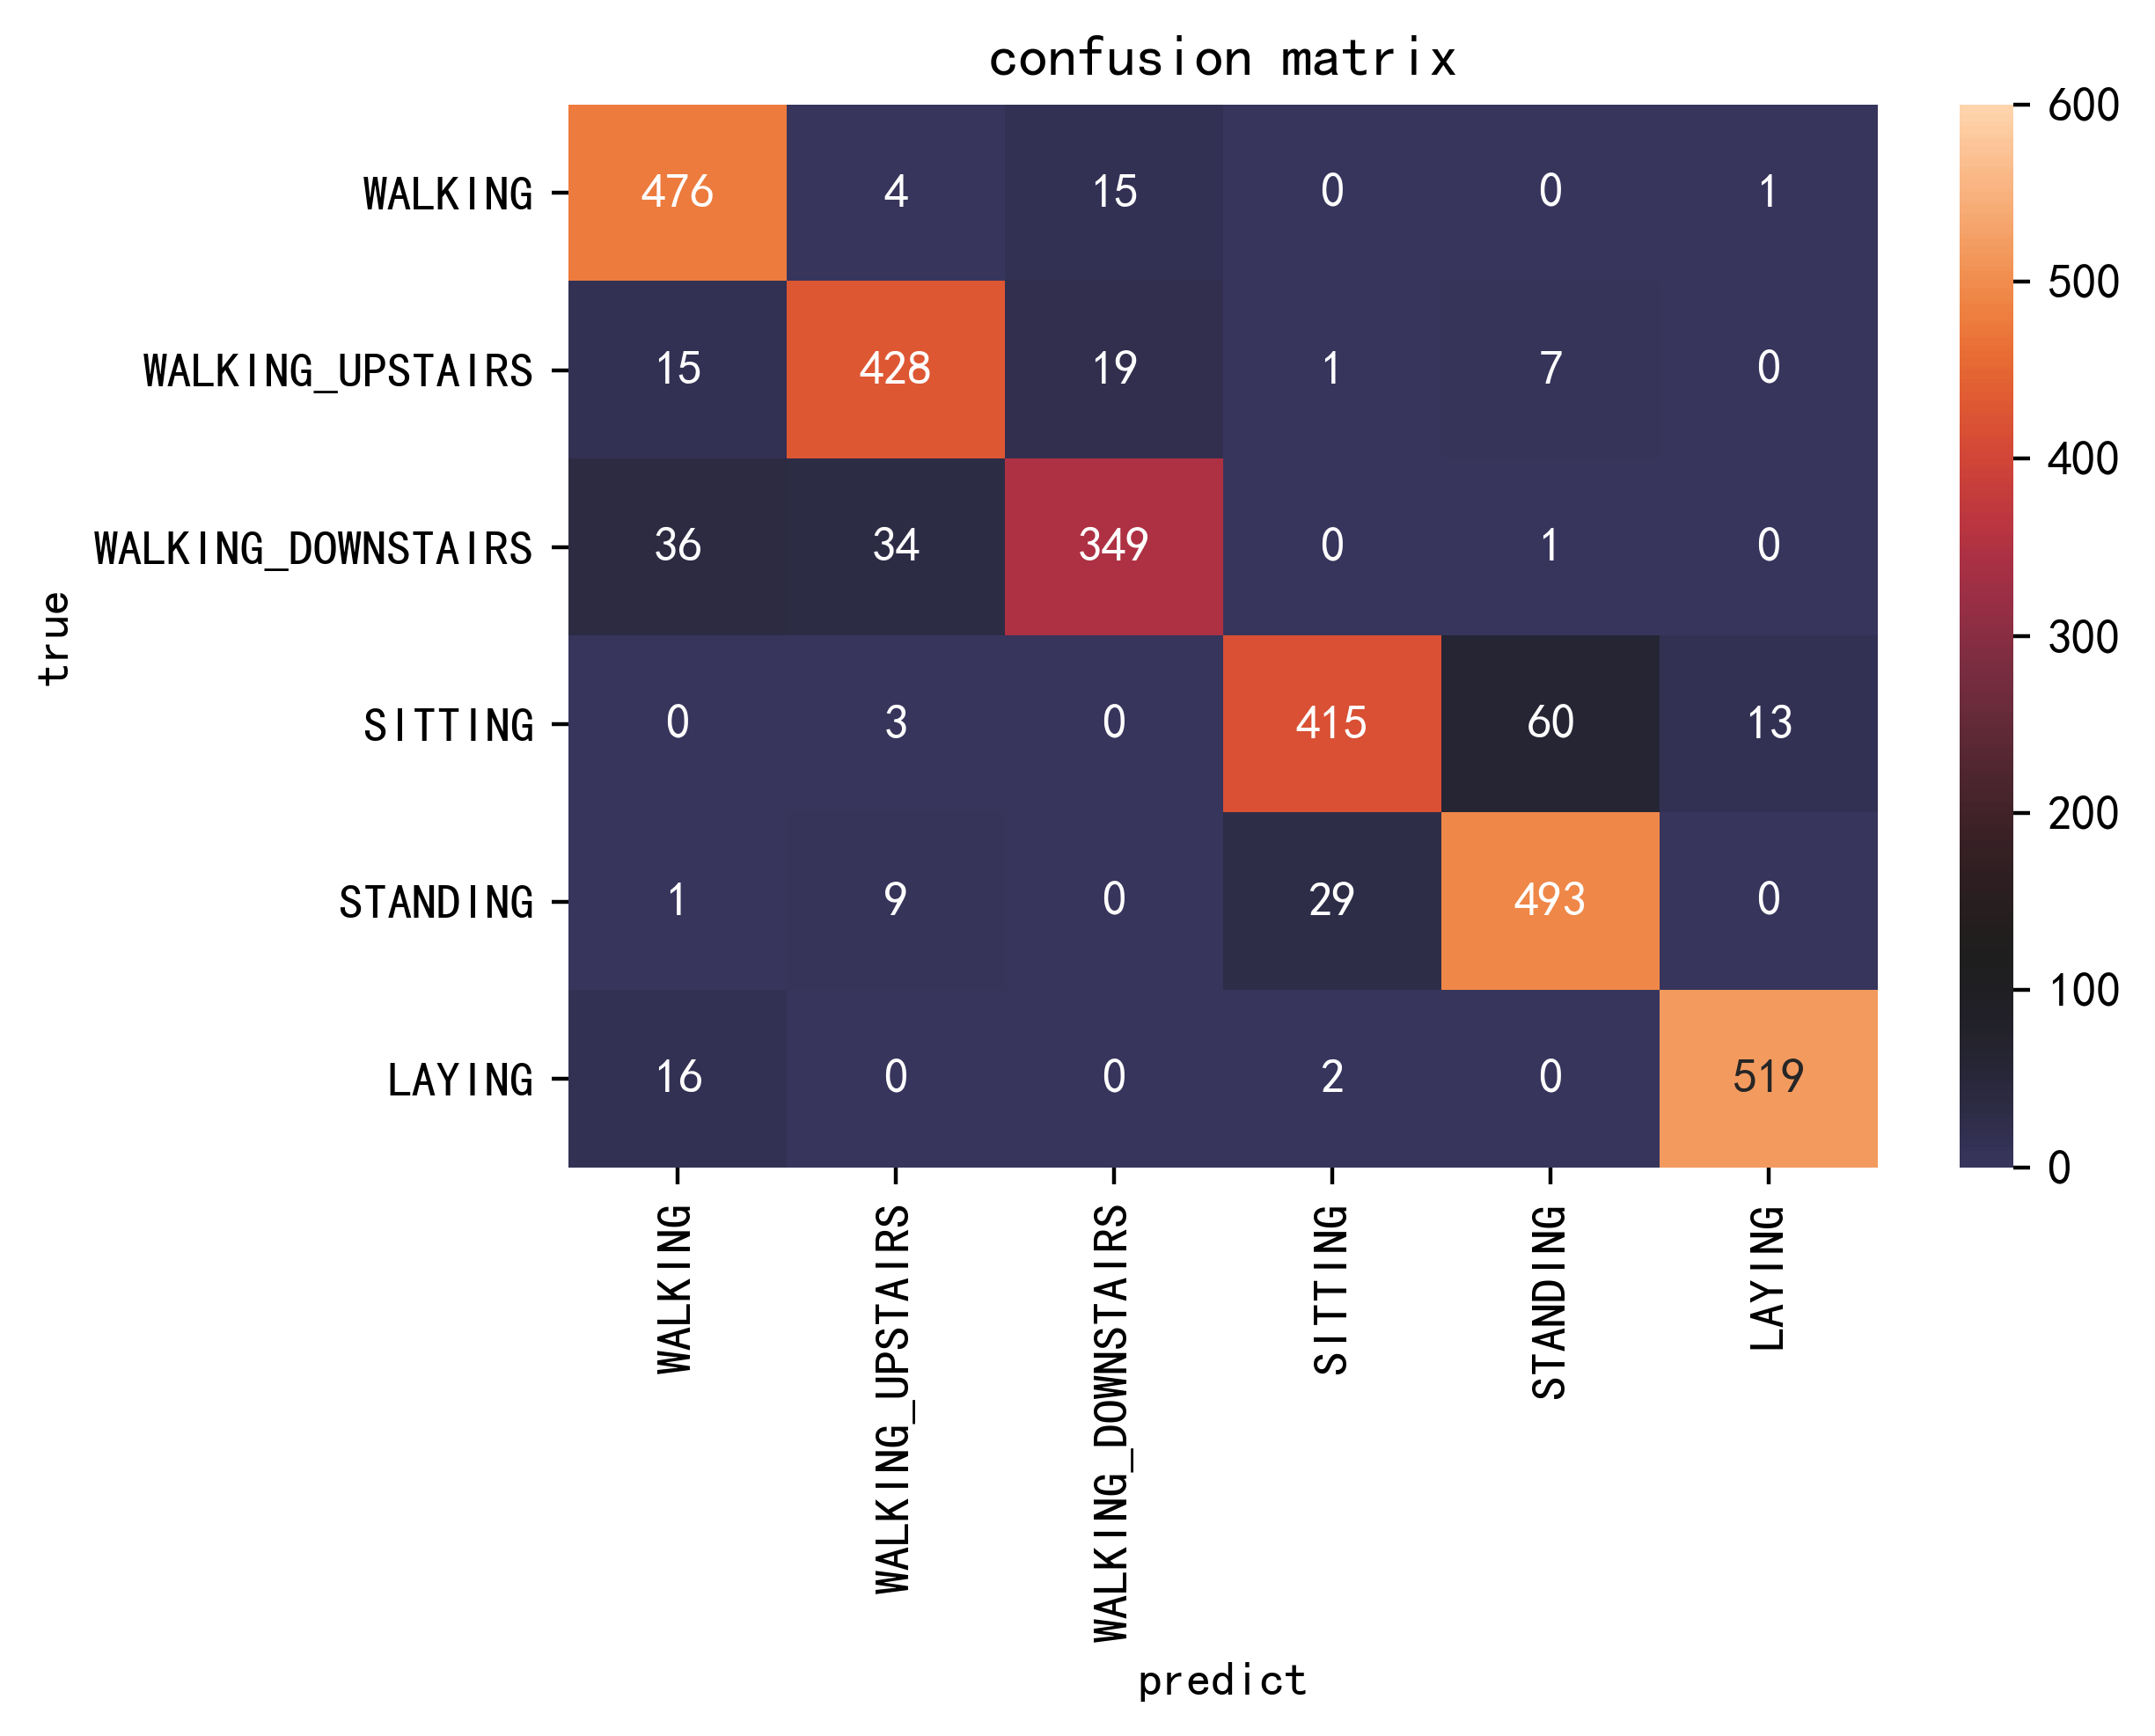

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,x_test)
prediction = lr.predict(y_train)
c = CreateCM(prediction,y_test,'LR')
process(c)

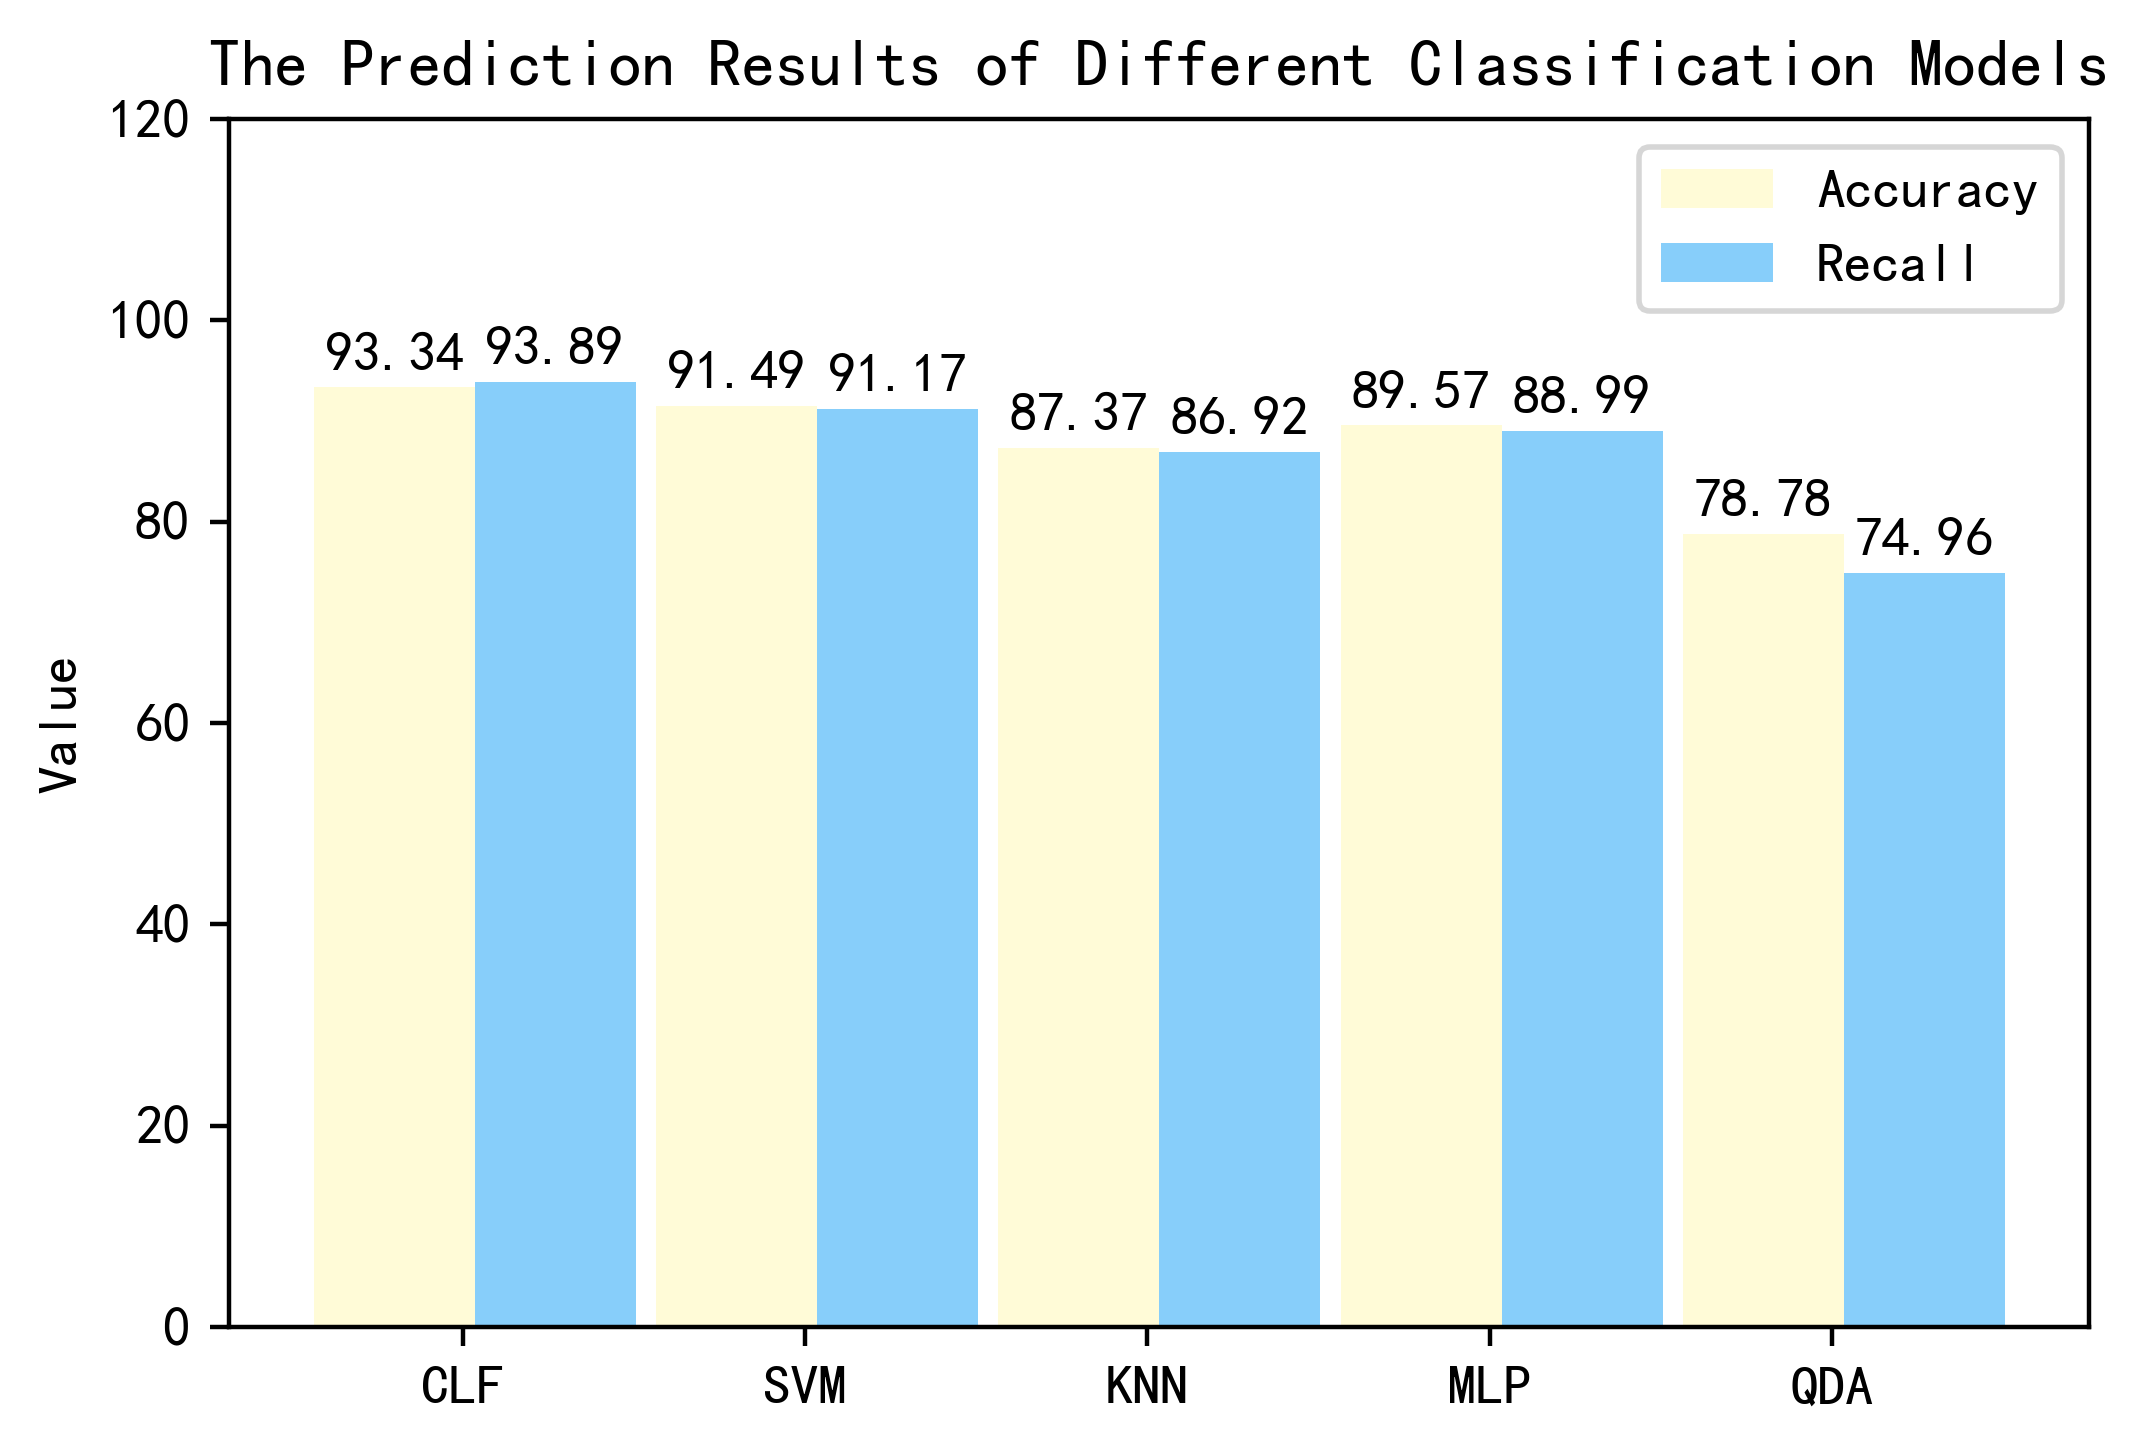

In [37]:
import matplotlib.pyplot as plt
import matplotlib
# 设置中文字体和负号正常显示
matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

label_list = ['CLF', 'SVM', 'KNN', 'MLP', 'QDA']    # 横坐标刻度显示值
num_list1 = [93.34, 91.49, 87.37, 89.57, 78.78]      # 纵坐标值1
num_list2 = [93.89, 91.17, 86.92, 88.99, 74.96]      # 纵坐标值2
x = range(len(num_list1))
"""
绘制条形图
left:长条形中点横坐标
height:长条形高度
width:长条形宽度，默认值0.8
label:为后面设置legend准备
"""
rects1 = plt.bar(x, height=num_list1, width=0.47, alpha=0.8, color='#FFFACD', label="Accuracy")
rects2 = plt.bar([i + 0.47 for i in x], height=num_list2, width=0.47, color='#87CEFA', label="Recall")
plt.ylim(0, 120)     # y轴取值范围
plt.ylabel("Value")
"""
设置x轴刻度显示值
参数一：中点坐标
参数二：显示值
"""
plt.xticks([index + 0.2 for index in x], label_list)
# plt.xlabel("百分率/%")
plt.title("The Prediction Results of Different Classification Models")
plt.legend()     # 设置题注
# 编辑文本
for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
for rect in rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")

plt.rcParams['savefig.dpi'] = 400 # 图片像素
plt.rcParams['figure.dpi'] = 400 # 分辨率
# plt.savefig('train_process/'+'对比实验结果'+'.tif',format='tif')
# plt.savefig('train_process/'+'对比实验结果'+'.jpg',format='jpg')
plt.show()